In [3]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("survey.csv")

# Display basic info
print("Shape:", df.shape)
df.head()

Shape: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


### Dataset overview

In [ ]:
# Structure
df.info()

# Basic stats
df.describe(include='all').T.head(15)

# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing[missing > 0])

# Duplicates
print("Number of duplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

### Data cleaning

In [ ]:
# Remove duplicates
df = df.drop_duplicates()

# Example: clean unrealistic ages
df = df[(df['Age'] >= 16) & (df['Age'] <= 70)]

# Standardize text values (example)
df['Gender'] = df['Gender'].str.lower().replace({
    'male-ish': 'male', 'm': 'male', 'man': 'male',
    'female': 'female', 'f': 'female', 'woman': 'female'
})

### Data visualization

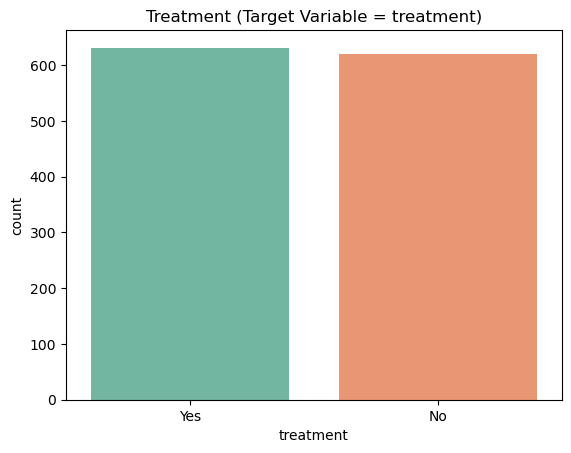

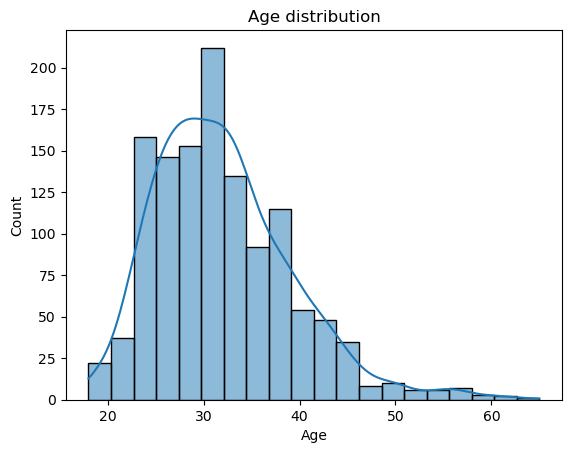

Only one numeric feature available (Age) — correlation heatmap not relevant.


In [6]:
# Distribution of target variable
sns.countplot(data=df, x='treatment', palette='Set2')
plt.title('Treatment (Target Variable = treatment)')
plt.show()

# Age distribution
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age distribution')
plt.show()

# Correlation heatmap (only numeric features)
numeric_df = df.select_dtypes(include=np.number)
if numeric_df.shape[1] > 1:
    plt.figure(figsize=(6,5))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap (numeric features)")
    plt.show()
else:
    print("Only one numeric feature available (Age) — correlation heatmap not relevant.")

# Keep a clean reference copy for the next step
df_eda = df.copy()


## EDA — Interpretation & comments

- **Dataset shape & structure:** The dataset has ≈1k rows with mixed **categorical** and **numeric** variables, which suits a supervised classification setup.
- **Data quality:** Some columns contain **missing values**; we also checked for **duplicates**. A light **age sanity filter (16–70)** removes obvious outliers.
- **Categorical harmonization:** Minimal normalization on **Gender** reduces spelling noise and cardinality without losing information.
- **Target inspection:** The target **`treatment`** (Yes/No) is **slightly imbalanced** (typically more “Yes”). We will consider **class weights** or **resampling** in modeling.
- **Univariate view:** Numeric features (e.g., *Age*) concentrate on young adults; after filtering, few extreme outliers remain.
- **Correlation:** The dataset currently contains only one numerical feature (Age), so the correlation matrix is trivial (correlation = 1 with itself).
Most variables are categorical, meaning relationships will be captured later through encoding and feature importance analysis rather than numeric correlation.

**Conclusion:** Data is clean enough to proceed. Key aspects for the next steps are **class imbalance** and **categorical heterogeneity** to handle in preprocessing and modeling.


# PRE PROCESSING

1) Define target and features

In [7]:
# Ensure the target exists
assert "treatment" in df_eda.columns, "Expected target column 'treatment' not found."

# Binary target: Yes -> 1, No -> 0
y = df_eda["treatment"].map({"Yes": 1, "No": 0})

# Features = all columns except the target
X = df_eda.drop(columns=["treatment"])

# Basic check of types
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Numeric features: {len(num_cols)} -> {num_cols}")
print(f"Categorical features: {len(cat_cols)} (showing first 10): {cat_cols[:10]}")


X shape: (1250, 26)
y shape: (1250,)
Numeric features: 1 -> ['Age']
Categorical features: 25 (showing first 10): ['Timestamp', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company']


### Define target & features

- We convert the target **`treatment`** to a binary label: *Yes → 1*, *No → 0*.
- Features `X` include all columns **except** the target.
- We list **numeric** vs **categorical** features for later transformers.
- This split is standard for binary classification and prepares the preprocessing stage.


2) Train/Test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y  # preserve class ratio under imbalance
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)
print("Class ratio (train):")
print(y_train.value_counts(normalize=True).rename(lambda v: f"class_{v}"))
print("Class ratio (test):")
print(y_test.value_counts(normalize=True).rename(lambda v: f"class_{v}"))

Train shapes: (1000, 26) (1000,)
Test  shapes: (250, 26) (250,)
Class ratio (train):
treatment
class_1    0.505
class_0    0.495
Name: proportion, dtype: float64
Class ratio (test):
treatment
class_1    0.504
class_0    0.496
Name: proportion, dtype: float64


### Stratified split

- We split the data into **80% train / 20% test** with a **stratified** strategy to keep the same class proportions in both sets.
- This is important because our target is **slightly imbalanced**.
- The random seed (`random_state=42`) ensures **reproducibility**.


3) Define transformers

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Numeric pipeline: median imputation + standardization
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: most-frequent imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

numeric_transformer, categorical_transformer

(Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler())]),
 Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                 ('encoder',
                  OneHotEncoder(handle_unknown='ignore', sparse=False))]))

### Transformers

- **Numeric pipeline**:
  - **Median imputation** is robust to outliers.
  - **StandardScaler** centers/scales numeric features for algorithms sensitive to scale (e.g., SVM, KNN).
- **Categorical pipeline**:
  - **Most-frequent imputation** fills missing categories in a simple, stable way.
  - **One-Hot Encoding** converts categories into binary indicators; `handle_unknown="ignore"` prevents errors at inference.
- Keeping imputation/scaling/encoding inside Pipelines avoids **data leakage** and guarantees **reproducibility**.


4) ColumnTransformer preprocessor

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"  # keep only specified columns
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Timestamp', 'Gender', 'Country', 'state',
                                  'self_employed', 'family_history',
                                  'work_interfere', 'no_employees',
                                  'remote_work', 'tech_company', 'benefits',
                                  'care_options', 'wellness_program',
                                  'seek_help', 'anonymity', 'leave',
                                  'mental_health_consequence',
                                  'phys_health_consequence', 'coworkers',
                                  'supervisor', 'mental_health_interview',
                                  'phys_health_interview', 'mental_vs_physical',
                                  'obs_consequence', 'comments'])])

### ColumnTransformer

- We **combine** the numeric and categorical pipelines into a single **`preprocessor`**.
- This guarantees that **the same transformations** are applied consistently in:
  - model training,
  - cross-validation,
  - grid search,
  - and final evaluation.
- Setting `remainder="drop"` ensures we only keep the columns we explicitly manage.


5) Sanity check: fit-transform & shapes

In [ ]:
# Fit on train, transform both train and test
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("Processed train shape:", X_train_proc.shape)
print("Processed test  shape:", X_test_proc.shape)

# Optional: quick density check on scaled numeric part
# (Only if there is at least one numeric feature)
import numpy as np
if len(num_cols) > 0:
    # Recover the numeric block indices (0..len(num_cols)-1 after transformation, since encoder expands later)
    print(f"Numeric features count: {len(num_cols)}")
else:
    print("No numeric features detected at this stage.")

Processed train shape: (1000, 1299)
Processed test  shape: (250, 1299)
Numeric features count: 1


### Sanity check

- We **fit** the preprocessor on the **training set only** and then **transform** both train and test.
- The resulting shapes confirm that preprocessing runs correctly.
- The increase in the number of columns is expected due to **One-Hot Encoding** of categorical variables.
- This step validates that our pipeline is ready to be wrapped with any **estimator** (LogReg, SVM, Tree, etc.).


# Correlation Heatmap after encoding

Top 10 features most correlated with 'treatment':


treatment                     1.000000
cat__family_history_Yes       0.373366
cat__care_options_Yes         0.264841
cat__work_interfere_Often     0.256733
cat__benefits_Yes             0.201408
cat__Gender_female            0.176446
cat__obs_consequence_Yes      0.164807
cat__work_interfere_Rarely    0.147737
cat__anonymity_Yes            0.140777
cat__leave_Very difficult     0.117989
Name: treatment, dtype: float64

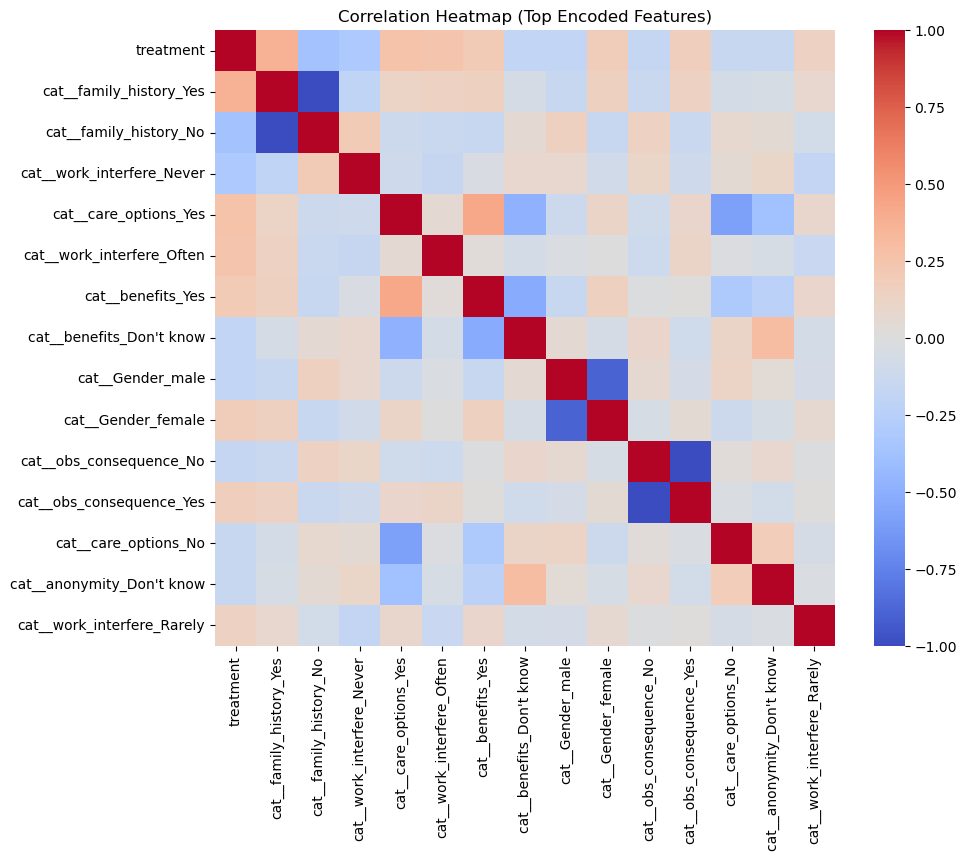

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get encoded feature names
encoded_feature_names = preprocessor.get_feature_names_out()

# Recreate DataFrame from encoded train data
X_train_encoded_df = pd.DataFrame(
    X_train_proc,
    columns=encoded_feature_names,
    index=X_train.index
)

# Compute correlation matrix
corr_matrix = X_train_encoded_df.corr()


X_corr_target = X_train_encoded_df.copy()
X_corr_target["treatment"] = y_train.values
corr_with_target = X_corr_target.corr()["treatment"].sort_values(ascending=False)

print("Top 10 features most correlated with 'treatment':")
display(corr_with_target.head(10))

# Plot a global heatmap (only for the top correlated features for readability)
top_features = corr_with_target.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(10, 8))
sns.heatmap(
    X_corr_target[top_features].corr(),
    annot=False,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap (Top Encoded Features)")
plt.show()

### Correlation Heatmap after encoding — Interpretation

- The encoded correlation matrix now highlights the relationships between categorical features and the target variable **`treatment`**.
- Features like **`family_history_Yes`**, **`care_options_Yes`**, and **`work_interfere_Often`** show positive correlation with `treatment`, meaning that employees with these characteristics are more likely to have received mental health treatment.
- Conversely, features such as **`work_interfere_Never`** or **`family_history_No`** show negative correlation.
- This confirms that the dataset contains meaningful relationships that can be leveraged by our classification models.


6) Modeling template with the preprocessor (example)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline as SKPipeline

# Example baseline model: Logistic Regression with class weights
baseline_clf = SKPipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=200, class_weight="balanced"))
])

# Fit on the raw X_train (preprocessing happens inside)
baseline_clf.fit(X_train, y_train)

print("Baseline train score:", baseline_clf.score(X_train, y_train))
print("Baseline test  score:",  baseline_clf.score(X_test, y_test))

Baseline train score: 0.885
Baseline test  score: 0.768


### Modeling template

- We wrap the **`preprocessor`** and a **baseline classifier** in a single **Scikit-Learn `Pipeline`**.
- Using `class_weight="balanced"` gives the baseline some robustness to class imbalance.
- Next steps:
  - add **cross-validation** and **GridSearchCV**,
  - compare several **baseline algorithms** (Logistic Regression, Decision Tree, KNN, SVM),
  - then move to **ensemble models** (RandomForest, XGBoost, Stacking) and an **MLP** for the advanced part.


In [ ]:
import joblib

# Save the preprocessing pipeline
joblib.dump(preprocessor, "preprocessor.pkl")

# Save train/test sets
joblib.dump(X_train, "X_train.pkl")
joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_train, "y_train.pkl")
joblib.dump(y_test, "y_test.pkl")

print("All files saved successfully!")

All files saved successfully!
